In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import math
from scipy.spatial.distance import euclidean

In [2]:
# Convert to DataFrame
df = pd.read_csv('../data/interim/unzipped/df_mouse_p1p2.csv')

df


/var/folders/9d/bxxrjx5d1qg5y0x87t0hp84w0000gn/T/ipykernel_82729/3949155861.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/interim/unzipped/df_mouse_p1p2.csv')


,session_id,mousemove_times,mousemove_type,mousemove_behaviour,label,mousemove_client_height_width
0,0ht0u328t4mkgi01sp7mm07e01,447717248,m,"(0,5)",moderate_bot,NaN
1,0ht0u328t4mkgi01sp7mm07e01,447717265,m,"(0,6)",moderate_bot,NaN
2,0ht0u328t4mkgi01sp7mm07e01,447717281,m,"(0,7)",moderate_bot,NaN
3,0ht0u328t4mkgi01sp7mm07e01,447717298,m,"(0,8)",moderate_bot,NaN
4,0ht0u328t4mkgi01sp7mm07e01,447717315,m,"(0,9)",moderate_bot,NaN
...,...,...,...,...,...,...
5250702,rh5fn2njcglhb2avkv30id017u,1595505964115,m,"(1082,94)",human,"(639, 1354)"
5250703,rh5fn2njcglhb2avkv30id017u,1595505964132,m,"(1140,54)",human,"(639, 1354)"
5250704,rh5fn2njcglhb2avkv30id017u,1595505964149,m,"(1182,26)",human,"(639, 1354)"
5250705,rh5fn2njcglhb2avkv30id017u,1595505964166,m,"(1214,8)",human,"(639, 1354)"


In [3]:
def calculate_all_features(df):
    all_features = {}

    for session, group in df.groupby('session_id'):
        group = group.sort_values('mousemove_times')

        coords = []
        times = []

        for i, row in group.iterrows():
            behavior = row['mousemove_behaviour']
            if isinstance(behavior, str) and '(' in behavior and ',' in behavior:
                try:
                    x = int(behavior.split('(')[1].split(',')[0])
                    y = int(behavior.split(',')[1].split(')')[0])
                    coords.append((x, y))
                    times.append(row['mousemove_times'])
                except (IndexError, ValueError):
                    continue

        if len(coords) < 3:
            continue

        features = {}

        # ----- 1. Movement Speed Variability ----- #
        speeds = []
        for i in range(1, len(coords)):
            dx = coords[i][0] - coords[i - 1][0]
            dy = coords[i][1] - coords[i - 1][1]
            distance = (dx**2 + dy**2)**0.5
            time_diff = (times[i] - times[i - 1]) / 1000

            if time_diff > 0:
                speed = distance / time_diff
                if speed < 5000:
                    speeds.append(speed)

        if speeds:
            mean_speed = sum(speeds) / len(speeds)
            std_speed = (sum((s - mean_speed)**2 for s in speeds) / len(speeds))**0.5
            features['speed_cv'] = std_speed / mean_speed if mean_speed > 0 else 0
        else:
            features['speed_cv'] = None

        # ----- 2. Cursor Hover Patterns ----- #
        hover_radius = 25
        min_hover_time = 300

        hover_events = []
        hover_durations = []

        current_hover_start = 0
        current_hover_center = None

        for i in range(1, len(coords)):
            if current_hover_center is None:
                current_hover_center = coords[i - 1]
                current_hover_start = times[i - 1]

            dx = coords[i][0] - current_hover_center[0]
            dy = coords[i][1] - current_hover_center[1]
            distance = (dx**2 + dy**2)**0.5

            if distance > hover_radius:
                hover_duration = times[i - 1] - current_hover_start
                if hover_duration >= min_hover_time:
                    hover_events.append(current_hover_center)
                    hover_durations.append(hover_duration)

                current_hover_center = coords[i]
                current_hover_start = times[i]

        if current_hover_center is not None:
            hover_duration = times[-1] - current_hover_start
            if hover_duration >= min_hover_time:
                hover_events.append(current_hover_center)
                hover_durations.append(hover_duration)

        features['hover_frequency'] = len(hover_events) / (len(coords) / 100) if len(coords) > 0 else 0
        features['avg_hover_duration'] = sum(hover_durations) / len(hover_durations) if hover_durations else 0


        # ----- 4. Acceleration Profile ----- #
        accelerations = []
        for i in range(1, len(speeds)):
            speed_diff = speeds[i] - speeds[i - 1]
            time_diff = (times[i] - times[i - 2]) / 1000

            if time_diff > 0:
                acceleration = speed_diff / time_diff
                if -10000 < acceleration < 10000:
                    accelerations.append(acceleration)

        if accelerations:
            mean_acc = sum(accelerations) / len(accelerations)
            std_acc = (sum((a - mean_acc)**2 for a in accelerations) / len(accelerations))**0.5
            skewness = sum(((a - mean_acc) / std_acc)**3 for a in accelerations) / len(accelerations) if std_acc > 0 else 0
            pos_acc = sum(1 for a in accelerations if a > 0)
            neg_acc = sum(1 for a in accelerations if a < 0)
            pos_neg_ratio = pos_acc / neg_acc if neg_acc > 0 else float('inf')

            features['acceleration_mean'] = mean_acc
            features['acceleration_std'] = std_acc
            features['acceleration_skewness'] = skewness
            features['acceleration_pos_neg_ratio'] = pos_neg_ratio
        else:
            features['acceleration_mean'] = None
            features['acceleration_std'] = None
            features['acceleration_skewness'] = None
            features['acceleration_pos_neg_ratio'] = None

        # ----- 5. Direction Change Frequency ----- #
        angle_threshold = 45
        direction_changes = 0

        for i in range(2, len(coords)):
            v1 = (coords[i - 1][0] - coords[i - 2][0], coords[i - 1][1] - coords[i - 2][1])
            v2 = (coords[i][0] - coords[i - 1][0], coords[i][1] - coords[i - 1][1])

            mag_v1 = (v1[0]**2 + v1[1]**2)**0.5
            mag_v2 = (v2[0]**2 + v2[1]**2)**0.5

            if mag_v1 > 0 and mag_v2 > 0:
                dot_product = v1[0]*v2[0] + v1[1]*v2[1]
                cos_angle = max(min(dot_product / (mag_v1 * mag_v2), 1.0), -1.0)
                angle = math.degrees(math.acos(cos_angle))
                if angle > angle_threshold:
                    direction_changes += 1

        total_distance = 0
        for i in range(1, len(coords)):
            dx = coords[i][0] - coords[i - 1][0]
            dy = coords[i][1] - coords[i - 1][1]
            total_distance += (dx**2 + dy**2)**0.5

        features['direction_change_frequency'] = direction_changes / (total_distance / 100) if total_distance > 0 else 0

        # ----- 6. Idle-to-Active Time Ratio ----- #
        idle_threshold = 500
        idle_time = 0
        active_time = 0

        for i in range(1, len(times)):
            time_diff = times[i] - times[i - 1]
            if time_diff > idle_threshold:
                idle_time += time_diff
            else:
                active_time += time_diff

        features['idle_active_ratio'] = idle_time / active_time if active_time > 0 else float('inf')

        # Store features
        all_features[session] = features

    return all_features

In [4]:
features = calculate_all_features(df)

features_df = pd.DataFrame.from_dict(features, orient='index').reset_index().rename(columns={'index': 'session_id'})

# Get session-wise labels from the original df
session_labels = df[['session_id', 'label']].drop_duplicates(subset='session_id')

# Merge labels into features_df
features_df = features_df.merge(session_labels, on='session_id', how='left')



In [5]:
features_df

,session_id,speed_cv,hover_frequency,avg_hover_duration,acceleration_mean,acceleration_std,acceleration_skewness,acceleration_pos_neg_ratio,direction_change_frequency,idle_active_ratio,label
0,03jt2p4bdru20sjb9me2gco6j4,1.292750,3.265045,10044.058824,-97.987654,4076.554706,0.137302,0.835740,0.550618,4.248230e+07,human
1,071tbv7fsev5d64kb0f9jieor6,0.509696,0.965173,1951.275000,-3.079521,1211.355072,-0.234733,1.013543,0.235069,2.274826e+00,advanced_bot
2,094i85crhkpkhqpi3rl4athrn4,0.517826,0.218432,966.923077,-94.009643,2813.920800,-0.017841,0.936106,0.246734,7.828571e+06,advanced_bot
3,0ht0u328t4mkgi01sp7mm07e01,0.232604,3.927866,866.327044,-2.978588,616.098440,0.029983,0.984024,33.136932,1.028202e+00,moderate_bot
4,0i5kvpslrq3vb6u8ff2kuejv0v,0.508165,0.895245,2000.883117,-0.205002,1173.942929,-0.054982,1.024497,0.245092,2.184613e+00,advanced_bot
...,...,...,...,...,...,...,...,...,...,...,...
444,vmgkfqtair7fq7kqqr6kpqm9st,0.305750,3.814194,411.760714,-22.634376,608.311077,0.822027,0.927207,13.736547,1.239705e+07,moderate_bot
445,vofhhjsbkpj6kc9it95e76nu1a,1.410842,2.760047,2101.642398,-227.235192,3651.905852,0.074954,0.812197,0.914448,3.544257e+06,human
446,vopb1c4o3o2dpsov8jinbbou5h,1.315861,0.447232,946.047170,-169.103916,4466.405098,0.044590,0.905222,0.022857,2.783891e-01,human
447,vtcjrbtjq57mnai4banl61pd25,0.498910,0.329584,2523.695652,1.611909,1139.847492,-0.085814,1.009751,0.236819,1.687842e+00,advanced_bot


In [6]:
features_df.to_csv('../data/interim/mousemovement_features.csv')

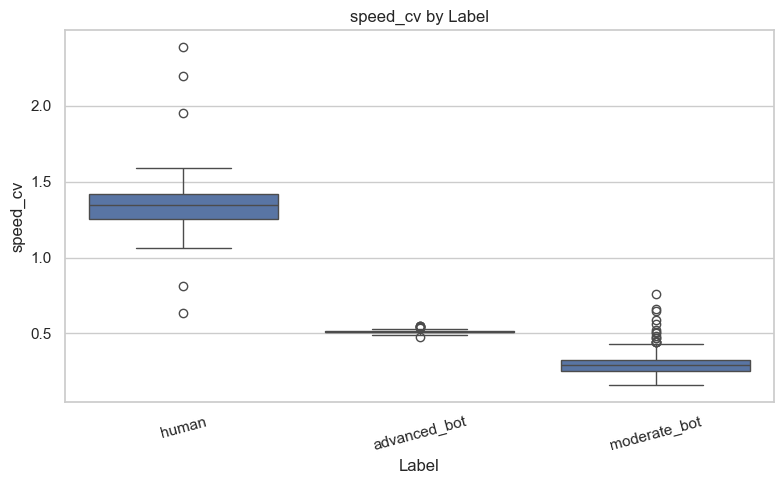

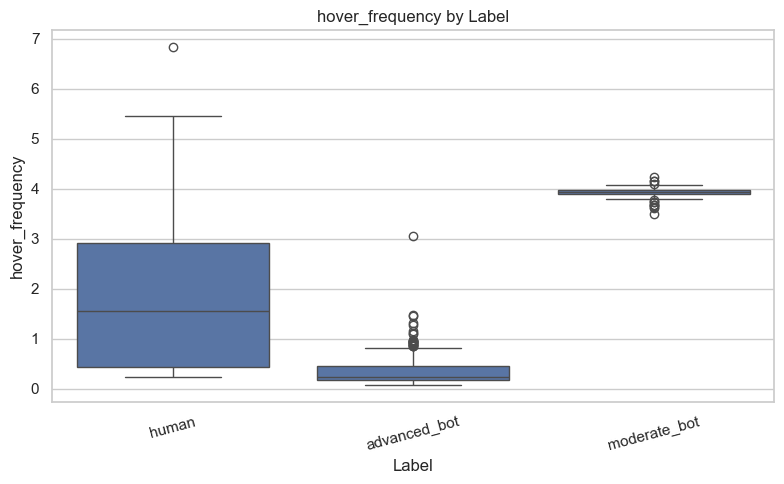

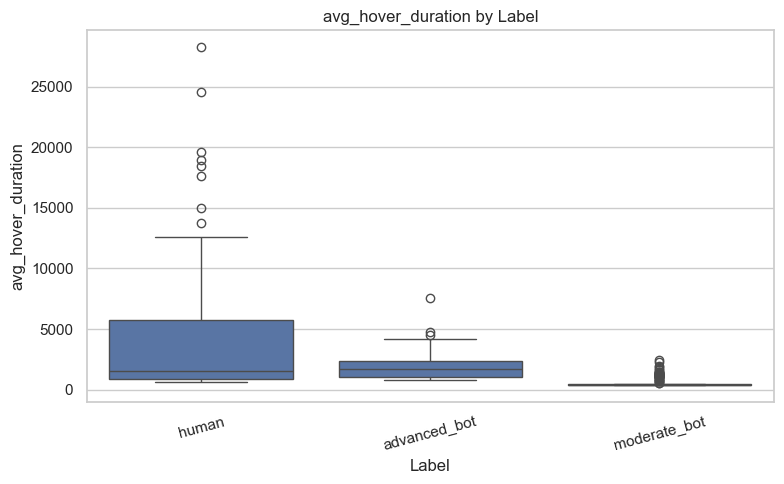

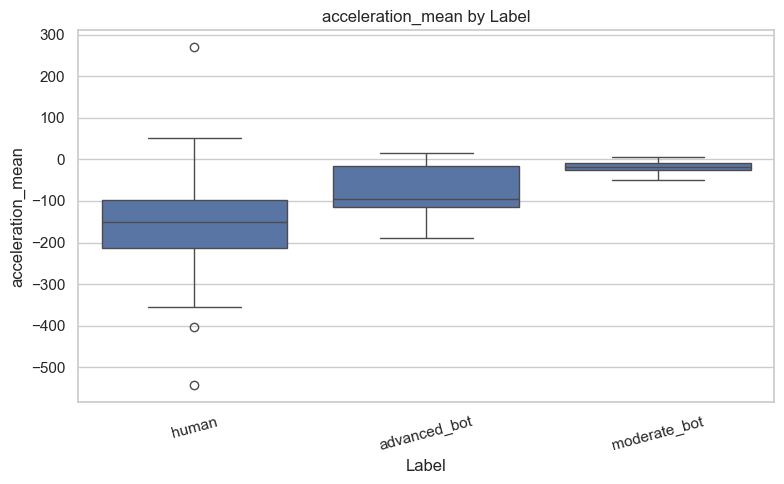

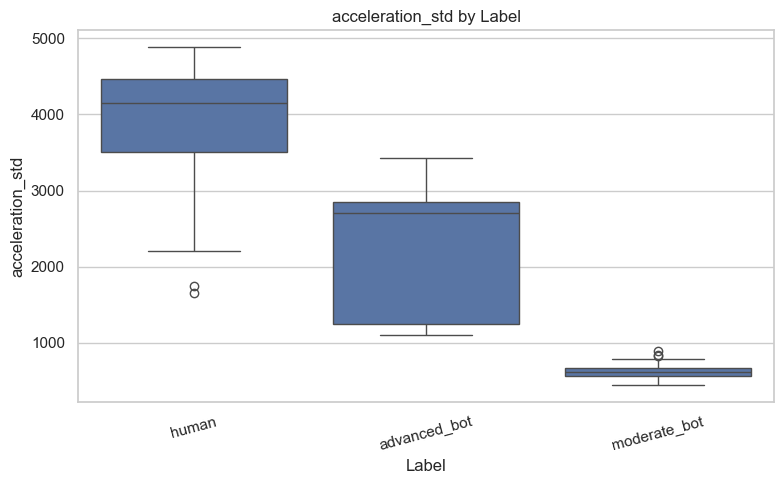

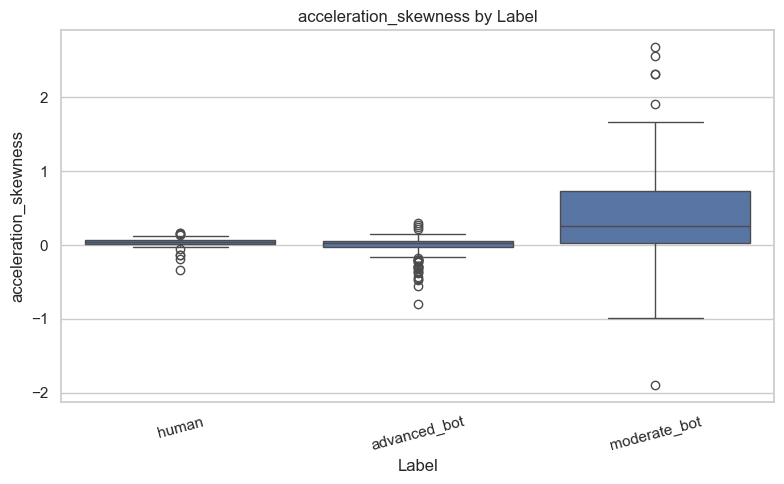

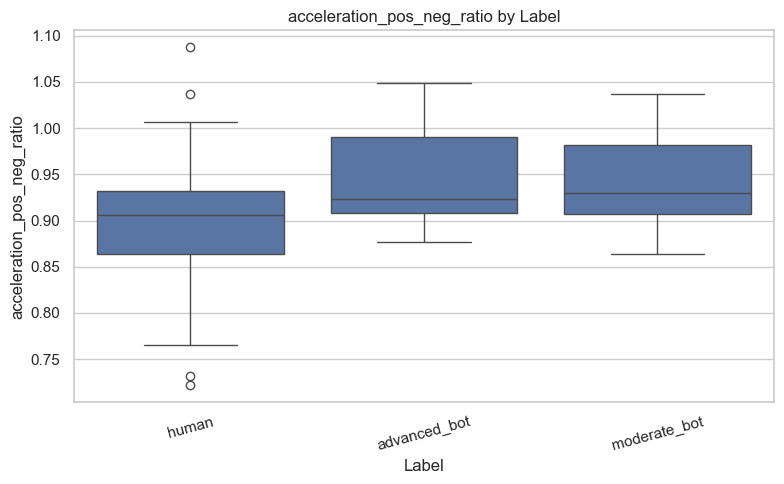

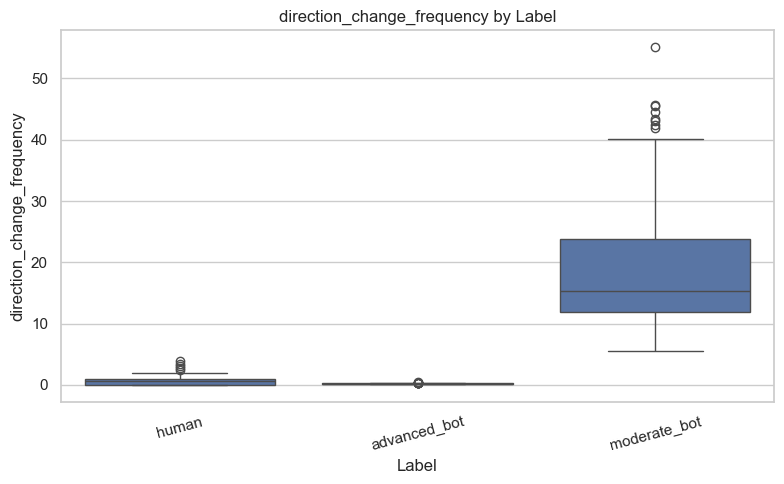

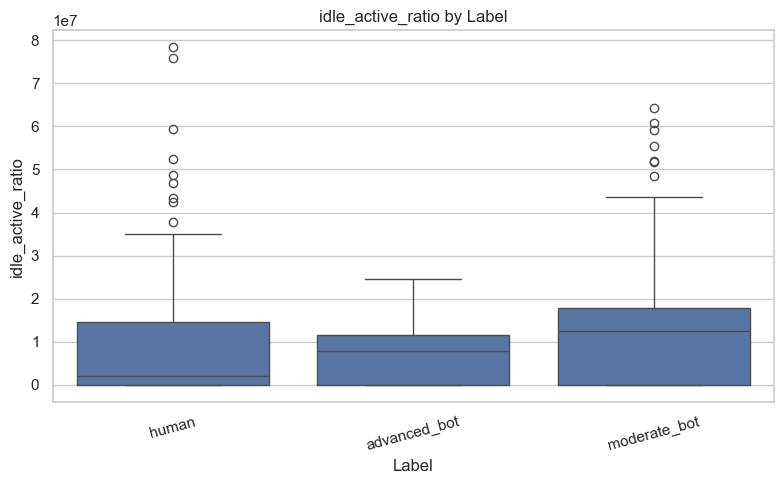

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# List of metrics (excluding session_id and label)
metric_columns = [
    'speed_cv', 'hover_frequency', 'avg_hover_duration',
    'acceleration_mean', 'acceleration_std', 'acceleration_skewness',
    'acceleration_pos_neg_ratio', 'direction_change_frequency',
    'idle_active_ratio'
]

# Plot each metric by label
for metric in metric_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='label', y=metric, data=features_df)
    plt.title(f'{metric} by Label')
    plt.xlabel('Label')
    plt.ylabel(metric)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()
